<a href="https://colab.research.google.com/github/s-choung/Research_utility/blob/main/pov_render_transparency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.0 MB/s eta 0:00:00


In [8]:
!sudo apt-get install povray

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-povray libsdl1.2debian povray-includes
Suggested packages:
  povray-doc povray-examples
The following NEW packages will be installed:
  fonts-povray libsdl1.2debian povray povray-includes
0 upgraded, 4 newly installed, 0 to remove and 24 not upgraded.
Need to get 1,739 kB of archives.
After this operation, 5,789 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fonts-povray all 1:3.7.0.8-4build1 [65.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libsdl1.2debian amd64 1.2.15+dfsg2-5 [175 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 povray amd64 1:3.7.0.8-4build1 [1,275 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 povray-includes all 1:3.7.0.8-4build1 [223 kB]
Fetched 1,739 kB in 1s (1,208 kB/s)
debconf: unable to initialize f

cell=Cell([3.8, 3.8, 3.8]), a=3.7999999999999994
# atoms target=100, actual 165


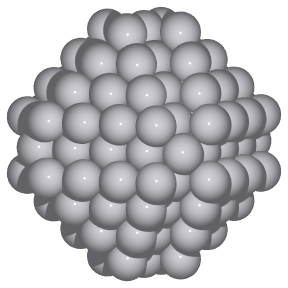

In [21]:
from ase.cluster import Decahedron, Icosahedron, Octahedron, wulff_construction
from ase.io import Trajectory
import pandas as pd
from ase.build import bulk
from ase.constraints import ExpCellFilter, StrainFilter
from ase.optimize import LBFGS
import numpy as np
from ase import Atoms
from ase.build import fcc111, add_adsorbate, bulk
from ase.io import read, write
from ase.io.pov import write_pov
from PIL import Image
from IPython.display import display

atoms_bulk = bulk("Pt", "fcc", a=3.8, cubic=True)
a = np.mean(np.diag(atoms_bulk.cell))
print(f"cell={atoms_bulk.cell}, a={a}")

def cluster2atoms(cluster):
    return Atoms(cluster.symbols, cluster.positions, cell=cluster.cell)

surfaces = [(1, 0, 0), (1, 1, 0), (1, 1, 1)]
esurf = [1.856, 1.681, 1.488]
lc = a
size=100
Pt_3nm = wulff_construction("Pt", surfaces, esurf, size, "fcc", rounding="above", latticeconstant=lc)
print(f"# atoms target={size}, actual {len(Pt_3nm)}")

def render_and_display_np(structure, index, max_size=(100, 100)):
    renderer = write('{index}.pov', structure, rotation='20z,-85x')
    renderer.render()
    image_path = '{index}.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    display(img)
render_and_display_np(Pt_3nm,'./content/{index}',(300, 300))

In [64]:
!pip install --upgrade ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
#example modified from https://gitlab.com/ase/ase/-/merge_requests/114 this is old code so supposee to make some error in write. povray_settings will be needed i guess

import numpy as np

from ase import Atoms
from ase.io import write
from ase.lattice.surface import fcc100
from ase.lattice.surface import add_adsorbate

from ase.data.colors import jmol_colors

# the metal slab
atoms = fcc100('Pt', size = [4,10,3], vacuum = 10)
transmittances = [0 for a in atoms]
bonded_atoms = []

# the dissociating oxygen... fake some dissociation curve
upper_layer_idx = [a.index for a in atoms if a.position[-1] == np.max(atoms.get_positions()[:,-1])]

middle = np.max(atoms.get_positions()[upper_layer_idx][:,:2], axis=0)/2.

gas_dist = 1.1
max_height = 8.
min_height = 1.
max_dist = 6

# running index for the bonds
index = len(atoms)

for i, x in enumerate(np.linspace(0,1.5,6)):
    height = (max_height-min_height)*np.exp(-2*x) + min_height
    pos = middle + np.array([0,1])*(np.exp(1.5*x)/np.exp(1.5**2)*max_dist/2. + gas_dist/2.)
    add_adsorbate(atoms, 'O', height = height, position = pos)

    pos = middle - np.array([0,1])*(np.exp(1.5*x)/np.exp(1.5**2)*max_dist/2. + gas_dist/2.)
    add_adsorbate(atoms, 'O', height = height, position = pos)

    transmittances += [x/2]*2

    # we want bonds for the first two molecules
    if i < 2:
        bonded_atoms.append([len(atoms) - a for a in [1,2]])

textures = ['ase3' for a in atoms]

# add some semi-transparent bath (only in x/y direction for this example)
cell = atoms.get_cell()

idx = [a.index for a in atoms if a.symbol == 'Pt']

Nbulk = len(idx)
multiples = [0, 1, -1]
for i in multiples:
    for j in multiples:
            if i == j == 0:
                continue
            _atoms = atoms[idx].copy()
            _atoms.translate(i*cell[0] + j*cell[1])
            atoms += _atoms
            transmittances += [0.8] * Nbulk
            textures += ['pale'] * Nbulk

bbox = [-30, 10, 5, 25]

write('transmittance_example.pov', atoms,
      rotation='90z,-75x',
      show_unit_cell=0,povray_settings=dict(     display=False,
      pause=False,
      canvas_width=1024,
      bondatoms=bonded_atoms,
      camera_type='perspective',
      transmittances=transmittances,
      textures=textures)
      )


In [71]:
#example from https://wiki.fysik.dtu.dk/ase/ase/spacegroup/spacegroup.html

import ase.io as io
from ase.build import cut
from ase.spacegroup import crystal

a = 9.04
skutterudite = crystal(('Co', 'Sb'),
                       basis=[(0.25, 0.25, 0.25), (0.0, 0.335, 0.158)],
                       spacegroup=204,
                       cellpar=[a, a, a, 90, 90, 90])

# Create a new atoms instance with Co at origo including all atoms on the
# surface of the unit cell
cosb3 = cut(skutterudite, origo=(0.25, 0.25, 0.25), extend=1.01)

# Define the atomic bonds to show
bondatoms = []
symbols = cosb3.get_chemical_symbols()
for i in range(len(cosb3)):
    for j in range(i):
        if (symbols[i] == symbols[j] == 'Co' and
                cosb3.get_distance(i, j) < 4.53):
            bondatoms.append((i, j))
        elif (symbols[i] == symbols[j] == 'Sb' and
              cosb3.get_distance(i, j) < 2.99):
            bondatoms.append((i, j))
transmittances = [0.5 for a in atoms]

# Create nice-looking image using povray
renderer = io.write('spacegroup-cosb3.pov', cosb3,
                    rotation='90y',
                    radii=0.4,
                    povray_settings=dict(transmittances=transmittances,
                                         camera_type='perspective',
                                         canvas_width=320,
                                         bondlinewidth=0.07,
                                         bondatoms=bondatoms))

renderer.render()

PosixPath('/content/spacegroup-cosb3.png')

In [ ]:
from ase.io import write

def render_and_display_trans(structure, index, max_size=(100, 100)):
    transmittances = [0.9 for a in structure]
    renderer = write('{index}.pov', structure, rotation='20z,-85x',povray_settings=dict(transmittances=transmittances,
                                         camera_type='perspective',
                                         canvas_width=200,
                                         bondlinewidth=0.07))
    renderer.render()
    image_path = '{index}.png'
    img = Image.open(image_path)
    img.thumbnail(max_size, Image.LANCZOS)
    display(img)

render_and_display_trans(Pt_3nm,'./content/{index}3',(300, 300))

In [54]:
#example from https://bitbucket.org/andrewpeterson/pgroup/src/master/python/pgroup/ase/io.py
from ase import io
from hi import POV

traj = io.Trajectory('Au-diffusion.traj')
fixed = len(traj) - 1  # the image to show as solid
movingatoms = [94,]  # list of moving atoms we want to capture
repeat = (3, 3, 1)  # periodic extension

atoms = traj[fixed].repeat(repeat)
lookat = (atoms[89].position + atoms[92].position) / 2.
cameralocation = lookat + (0., -7., 12.)

pov = POV(atoms,
          pixelwidth=2.0*640,
          radii=1.0,
          look_at=lookat,
          cameralocation=cameralocation,
         )
pov.write('ghost.pov', run_povray=False)


def add_transparent_image(pov, atoms, movingatoms, transmit=0.7):
    """Adds the atoms to the pov file, but in a transparent manner.
    Only those atoms indexed in movingatoms are added. transmit is
    level of transparency."""
    for index in movingatoms:
        pos = atoms[index].position.copy()
        radius = pov._radii[index]
        color = pov._colors[index]
        line = ('sphere{<%.2f,%.2f,%.2f>, %.2f texture{pigment{rgb'
                ' <%.2f,%.2f,%.2f> transmit %.2f}}}'
                % (pos[0], pos[1], pos[2], radius,
                   color[0], color[1], color[2], transmit))
        with open(pov._filename, 'a') as f:
            f.write(line)

for count, atoms in enumerate(traj):
    print(count)
    if count == fixed:
        continue
    atoms = atoms.repeat(repeat)
    add_transparent_image(pov, atoms, movingatoms, transmit=0.7)

pov.raytrace()

0
1
2
3
4
5
6
